In [2]:
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Defino funciones

In [3]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [4]:
from sklearn.metrics import mean_absolute_error

def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    error = mean_absolute_error(test_labels, predict)
    score = model.score(test_features,test_labels)
    
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(score*100))
    print('Mean abs error: {:0.4f}.'.format(error))

    
    return predict

In [5]:
def transformar(df,colums,func):
    for x in colums:
        df[x]=df[x].transform(lambda y: func(y))
        
columnas_para_transformar = ["metroscubiertos","metrostotales","metroscubiertostotales"]

#transformar(df1,columnas_para_transformar,np.sqrt)

## Importo dataset

In [6]:
df = pd.read_csv('../data/features.csv')

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

In [7]:
df = df.drop(columns=["direccion","descripcion","titulo"])

 ## Completo los datos faltantes

In [8]:
oneHot = ['tipodepropiedad','provincia']
binary = ['ciudad']


df_ids = df["id"]
df = df.drop(columns=["id"])

In [9]:
#Completo los numericos
df1 = imputar(df)


#Completo los categoricos
imp = SimpleImputer(strategy="constant",fill_value="-")

df1["tipodepropiedad"] = imp.fit_transform(df1[["tipodepropiedad"]])
df1["provincia"] = imp.fit_transform(df1[["provincia"]])
df1["ciudad"] = imp.fit_transform(df1[["ciudad"]])

In [10]:
df1["metroscubiertostotales"]=df1["metroscubiertos"]+df1["metrostotales"]
df1["ambientes"]=df1["banos"]+df1["habitaciones"]
df1["ambientesygarage"]=df1["banos"]+df1["habitaciones"]+df1["garages"]

 ## Genero los encodes

In [11]:
data_cols = df1._get_numeric_data().columns
baseline_data = df1[data_cols]

encoder = ce.OneHotEncoder()

encoded = encoder.fit_transform(df1[oneHot])
data = baseline_data.join(encoded)

encoder = ce.BinaryEncoder()
encoded = encoder.fit_transform(df1[binary])
data = data.join(encoded)

data.shape

(240000, 108)



## Divido data set


In [12]:
x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 107) y=(240000,)
Train shapes: X=(192000, 107) y=(192000,)
Test  shapes: X=(48000, 107)  y=(48000,)



## Modelo y entreno

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 100,
                              min_samples_split = 3,
                              min_samples_leaf = 2,
                              max_features = 'log2',
                              bootstrap = False)

In [14]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Predicciones

In [15]:
predecir(model,x_train,y_train,x_test,y_test)

Entrenamiento: 82.8378%
Testeo: 79.8907%.
Mean abs error: 583946.7667.


array([7583495.86833157, 1035703.16627967, 6170863.50821511, ...,
       4506267.54611208, 9743752.2904475 , 1656092.77266621])

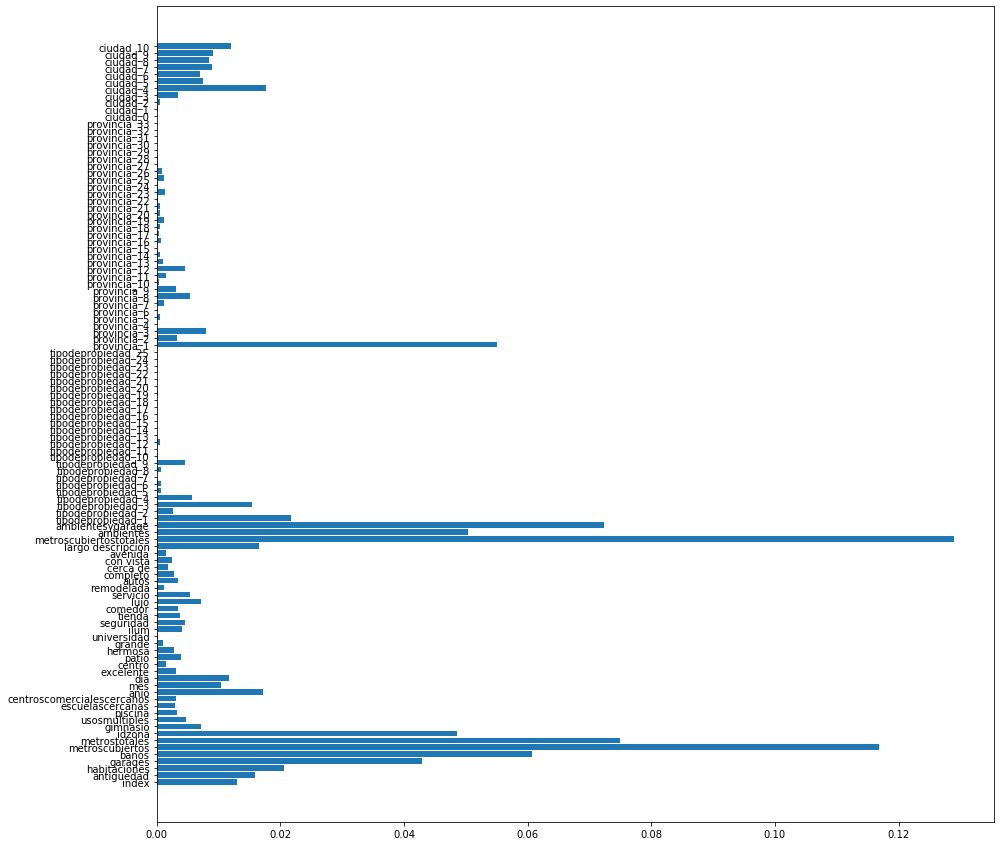

In [15]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_
ax = plt.barh(x.columns, importancia)